In [1]:
# import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [3]:
df = pd.read_csv('data.csv',encoding='unicode_escape')

In [4]:
df.shape

(162913, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162913 entries, 0 to 162912
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    162913 non-null  object 
 1   StockCode    162913 non-null  object 
 2   Description  162283 non-null  object 
 3   Quantity     162912 non-null  float64
 4   InvoiceDate  162912 non-null  object 
 5   UnitPrice    162912 non-null  float64
 6   CustomerID   113420 non-null  float64
 7   Country      162912 non-null  object 
dtypes: float64(3), object(5)
memory usage: 9.9+ MB


In [6]:
df.isna().sum()

InvoiceNo          0
StockCode          0
Description      630
Quantity           1
InvoiceDate        1
UnitPrice          1
CustomerID     49493
Country            1
dtype: int64

In [7]:
df['CustomerID'].nunique()

2410

In [8]:
# Convert InvoiceDate into date
df['Date'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
# Drop rows where CustometID is NA
df.dropna(subset=['CustomerID'], inplace=True)

In [10]:
# Keep rows with Max date of the purches for each customer
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min').astype(int)
df_rec = df[df['rank']==1]

In [11]:
# Rank each customer based on the recency of theirs purchase - assign recency score,
# computed as the number of days between each date and the earliest date
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

<ipython-input-11-679597ffb295>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


In [12]:
# calculate frequency - how many times each custome made a purchase
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID', 'frequency']

In [14]:

# add frequency column
rec_freq = df_freq.merge(df_rec, on = 'CustomerID')

In [19]:
# calculate Total for each row in df
rec_freq['Total'] = rec_freq['Quantity']*rec_freq['UnitPrice']

In [20]:
# find monetary value for each customer
m = rec_freq.groupby('CustomerID')['Total'].sum()
m = pd.DataFrame(m).reset_index()
m.columns = ['CustomerID','monetary_value']

In [21]:
# add monetary value column
rfm = m.merge(rec_freq, on = 'CustomerID')

In [22]:
# select the columns we will use to build the model
df_final = rfm[['CustomerID', 'recency', 'frequency','monetary_value']]

In [23]:
# remove duplicates
df_final.drop_duplicates(inplace=True)

<ipython-input-23-9466ccca8d24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.drop_duplicates(inplace=True)


In [24]:
df_final.head()

,CustomerID,recency,frequency,monetary_value
0,12346.0,48,1,77183.60
1,12347.0,6,31,711.79
32,12348.0,15,17,892.80
49,12350.0,63,17,334.40
66,12352.0,77,15,296.50


In [25]:
len(df_final)

2410

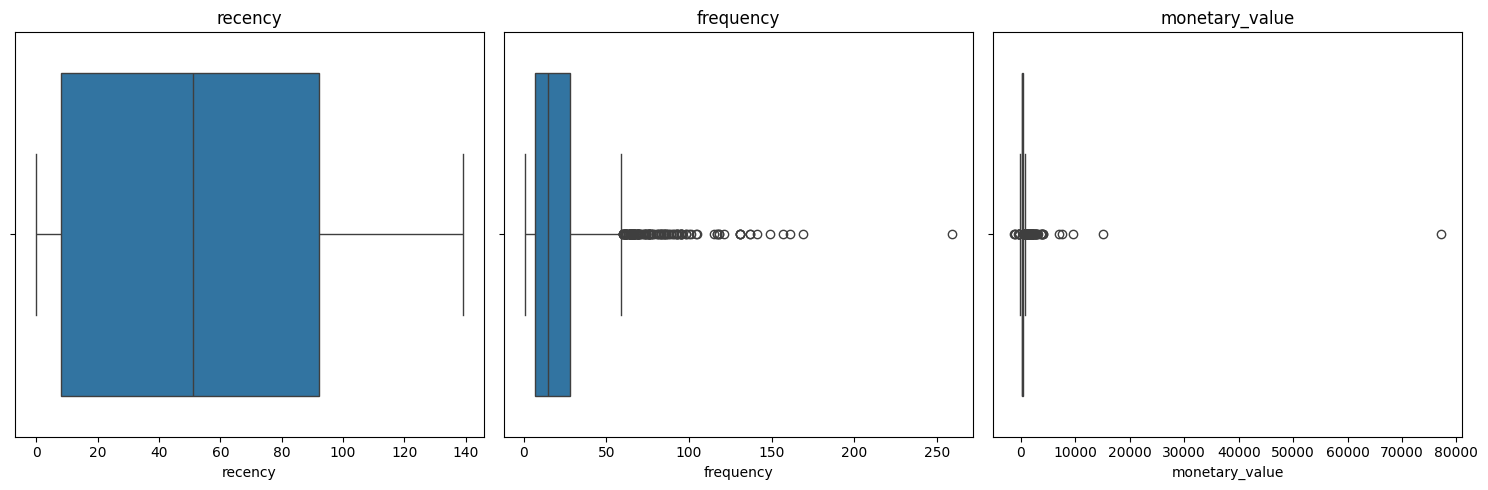

In [26]:
# visualuze data
rfm_list = ['recency', 'frequency', 'monetary_value']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.set_title(rfm_list[i])
    sns.boxplot(x=df_final[rfm_list[i]], ax=ax)

plt.tight_layout()
plt.show()

In [27]:
# remove the CustomerID column
new_df = df_final[['recency','frequency','monetary_value']]

In [28]:
# remove outliers
z_scores = stats.zscore(new_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = new_df[filtered_entries]

In [29]:
# check how many records were removed
len(df_final)-len(new_df)

49

In [30]:
# Apply Standard Scaler
new_df = new_df.drop_duplicates()
col_names = ['recency', 'frequency', 'monetary_value']
features = new_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)

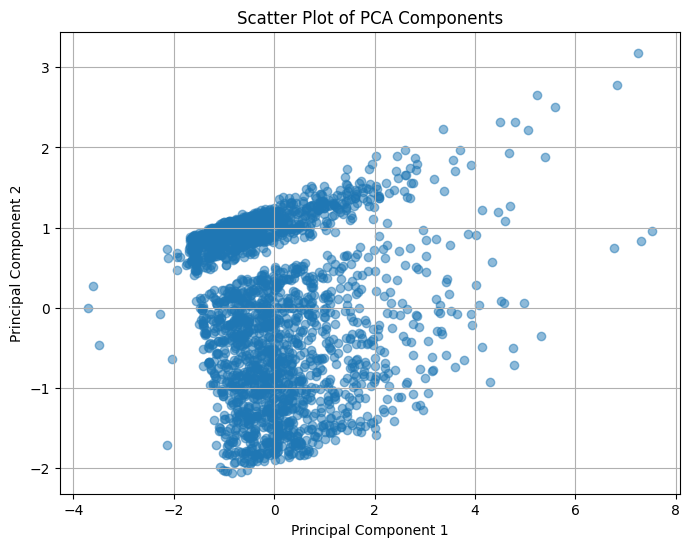

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to extract components
pca = PCA(n_components=2)
components = pca.fit_transform(scaled_features)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], alpha=0.5)
plt.title('Scatter Plot of PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia')

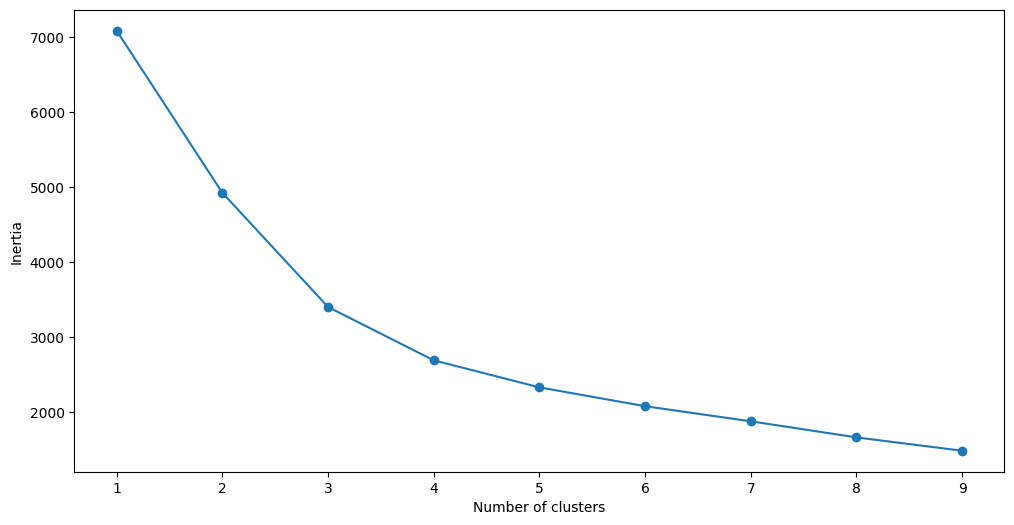

In [31]:
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_features)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


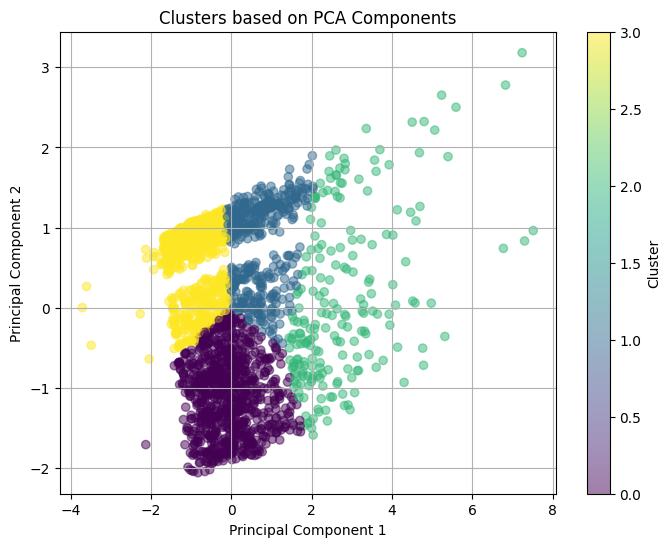

In [42]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=4)  # Specify the number of clusters
kmeans.fit(components)  # Fit K-means to the principal components
labels = kmeans.labels_  # Get cluster labels for each data point

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('Clusters based on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


In [32]:
# build a model with 4 clusters
kmeans = KMeans( n_clusters = 4, init='k-means++')
kmeans.fit(scaled_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

In [33]:
print(silhouette_score(scaled_features, kmeans.labels_, metric='euclidean'))

0.3956322489768608


In [34]:
# Assign clusters to each customer in the dataset:
pred = kmeans.predict(scaled_features)
frame = pd.DataFrame(new_df)
frame['cluster'] = pred

In [35]:
frame.head()

,recency,frequency,monetary_value,cluster
1,6,31,711.79,2
32,15,17,892.80,0
49,63,17,334.40,1
66,77,15,296.50,1
81,48,36,2271.62,3


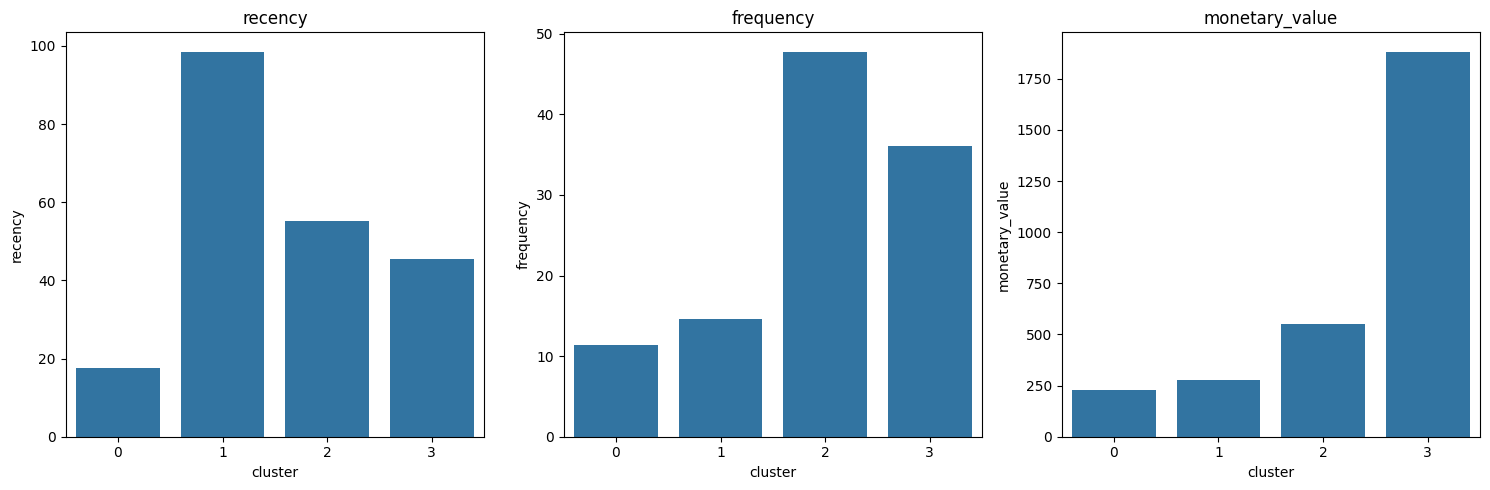

In [36]:
# Visualize data to identify distinct traits of each cluster

avg_df = frame.groupby(['cluster'], as_index=False).mean()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a single row of 3 subplots

for i, ax in enumerate(axes):
    sns.barplot(x='cluster', y=rfm_list[i], data=avg_df, ax=ax)
    ax.set_title(rfm_list[i])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [52]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'new_df' contains the data and has been preprocessed

# Step 1: Check the number of rows in the DataFrame
num_rows = len(new_df)

# Step 2: Select the number of rows to sample (minimum of 9000 or number of rows)
sample_size = min(9000, num_rows)

# Step 3: Select a random subset of rows
random_subset = new_df.sample(n=sample_size, random_state=42)

# Apply Standard Scaler
col_names = ['recency', 'frequency', 'monetary_value']
features = random_subset[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns=col_names)

# Create Agglomerative Hierarchical Clusters
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)


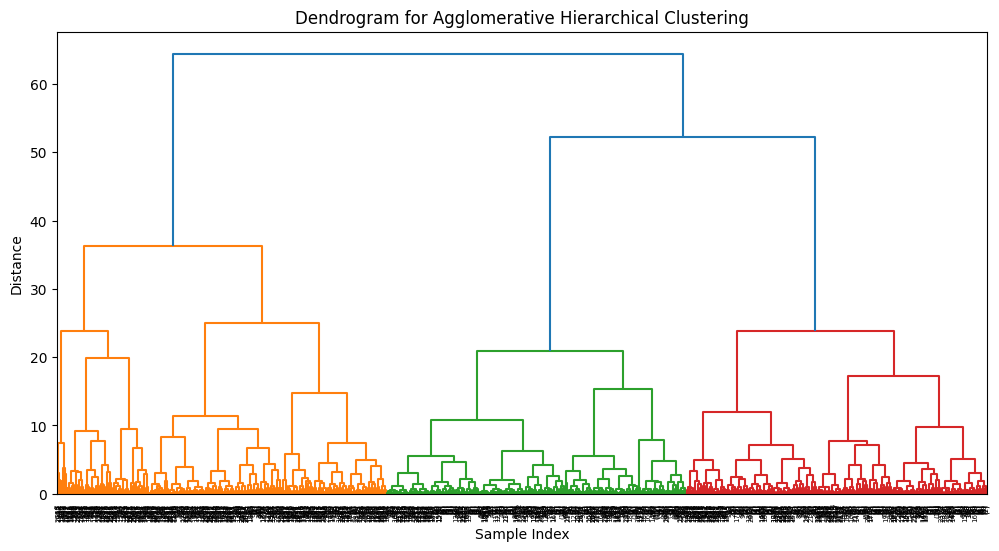

In [53]:
# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=10)  # Adjust 'p' as needed to control the number of levels shown
plt.title('Dendrogram for Agglomerative Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


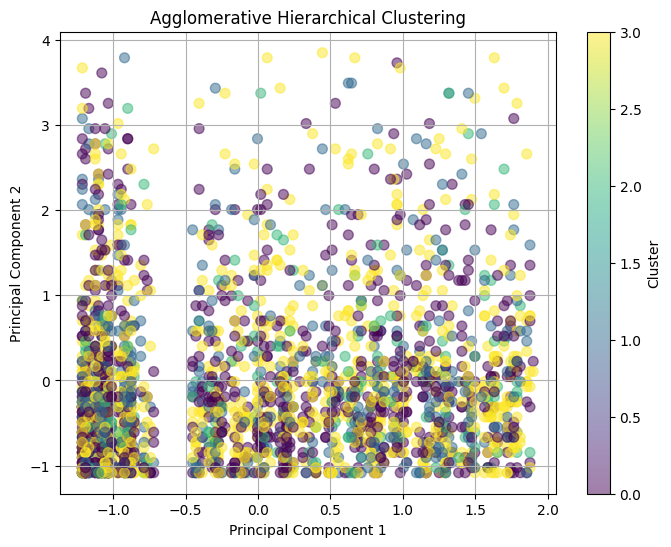

In [55]:


# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features.iloc[:, 0], scaled_features.iloc[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
plt.title('Agglomerative Hierarchical Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


**REPORT**

**INTRODUCTION**

The goal is to classify customers into segments based on theor buying behavour

The dataframe consists of 8 variables:

InvoiceNo: The unique identifier of each customer invoice.

StockCode: The unique identifier of each item in stock.

Description: The item purchased by the customer.

Quantity: The number of each item purchased by a customer in a single invoice.

InvoiceDate: The purchase date.

UnitPrice: Price of one unit of each item.

CustomerID: Unique identifier assigned to each user.

Country: The country from where the purchase was made.

**RESULTS**

The number "0.3956322489768608" is called the silhouette score. It tells us how much each item fits into its own group compared to others. A silhouette score closer to 1 indicates that data points within clusters are tightly grouped and well-separated from neighboring clusters. This suggests that the clustering is appropriate and the data points are clearly assigned to the correct clusters.

When you see "KMeans(n_clusters=4)," it means the data was split into four groups using a method called K-Means clustering. This splits the data based on similarities, with each item placed in the group that's most similar to it.

**COMPARISON**

**Size of Clustering:**

K-Means: In K-Means, the size of the clustering depends on the number of clusters specified by the parameter n_clusters. Each data point is then grouped into one of these clusters.

Agglomerative Hierarchical Clustering: The size of the clustering in agglomerative hierarchical clustering can vary. It's influenced by factors like the chosen linkage method and the distance threshold used to create clusters. This method can result in hierarchical clusters, where smaller ones are nested within larger ones.

**Comparison on Memory and Time Taken:**

K-Means: K-Means is generally less demanding in terms of memory and time compared to hierarchical clustering. This is particularly true for large datasets. K-Means only requires storing cluster centroids and data point assignments, leading to lower memory usage and faster computation.

Agglomerative Hierarchical Clustering: Hierarchical clustering, on the other hand, tends to be more resource-intensive and time-consuming, especially for larger datasets. This is because it needs to compute and store the entire dendrogram and linkage matrix.

**Composition of Each Cluster:**

For K-Means with a silhouette score of 0.3956 and 4 clusters.This splits the data based on similarities, with each item placed in the group that's most similar to it.

Agglomerative hierarchical clustering provides a hierarchical breakdown of data into clusters. This allows for analysis of cluster compositions at different hierarchy levels, offering insight into how data points are grouped.

**CONCLUSION**

Overall, the choice between K-Means and agglomerative hierarchical clustering depends on factors such as the dataset size, computational resources, and the desired level of cluster granularity. K-Means may be preferable for larger datasets or when a fixed number of clusters is desired, while agglomerative hierarchical clustering offers flexibility and insight into hierarchical relationships within the data.